In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

results = []

In [16]:
def load_and_preprocess_data(filepath):
    dataset = pd.read_excel(filepath)
    dataset = dataset.dropna()
    dataset = dataset.head(20000)
    dataset = dataset.select_dtypes(exclude=['object'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dataset)
    return data_scaled

data03_scaled = load_and_preprocess_data(r"arcgis_ngas_usak_v02.xlsx")

K-means 2 clusters - Silhouette Score: 0.2948713157695822
K-means 3 clusters - Silhouette Score: 0.23176527136543665
K-means 4 clusters - Silhouette Score: 0.22923088594894453
K-means 5 clusters - Silhouette Score: 0.23630805988209777
K-means 6 clusters - Silhouette Score: 0.24096399379981476
K-means 7 clusters - Silhouette Score: 0.24961649946733747
K-means 8 clusters - Silhouette Score: 0.24204301749516435
K-means 9 clusters - Silhouette Score: 0.22137925773579303
K-means 10 clusters - Silhouette Score: 0.18498123875895425
Max Silhouette score: 0.2948713157695822 (Cluster: 2)


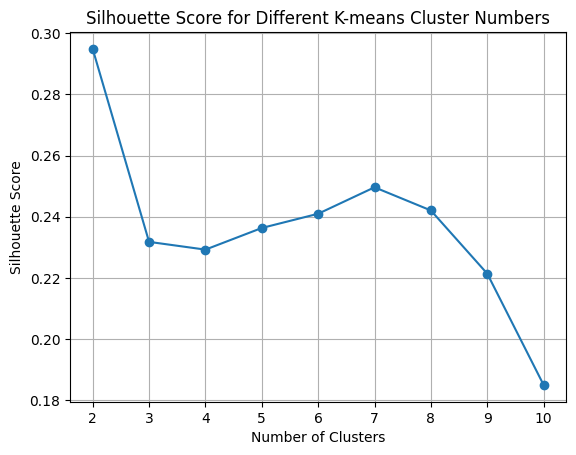

In [17]:
# Function to apply K-means clustering
def apply_kmeans(data, n_clusters=3, random_state=47):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette

# Function to compare K-means results with different cluster sizes
def compare_kmeans(data, cluster_range, random_state=47):
    results = []
    for n_clusters in cluster_range:
        clusters, silhouette = apply_kmeans(data, n_clusters, random_state)
        results.append((n_clusters, clusters, silhouette))
    return results

# Example usage with dataset data03_scaled and cluster range [2, 10]
cluster_range = range(2, 11)
kmeans_results = compare_kmeans(data03_scaled, cluster_range)

# Print silhouette scores for each number of clusters
for n_clusters, _, silhouette in kmeans_results:
    print(f'K-means {n_clusters} clusters - Silhouette Score: {silhouette}')

# Find the maximum silhouette score and corresponding number of clusters
silhouette_scores = [silhouette for _, _, silhouette in kmeans_results]
max_silhouette = max(silhouette_scores)
best_n_clusters = cluster_range[silhouette_scores.index(max_silhouette)]
print(f'Max Silhouette score: {max_silhouette} (Cluster: {best_n_clusters})')

# Visualize Silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K-means Cluster Numbers')
plt.grid(True)
plt.savefig('kmeans_silhouette_scores.png')  # Save the plot as PNG
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    unique_clusters = np.unique(clusters)
    if len(unique_clusters) > 1 and len(unique_clusters) < len(data):
        silhouette = silhouette_score(data[clusters != -1], clusters[clusters != -1])
        return clusters, silhouette
    else:
        return clusters, None

def compare_dbscan(data, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                clusters, silhouette = apply_dbscan(data, eps, min_samples)
                if silhouette is not None:
                    result = f'DBSCAN with eps={eps}, min_samples={min_samples}: Silhouette Score = {silhouette:.4f}'
                    results.append((eps, min_samples, silhouette))
            except ValueError:
                continue
    return results


eps_values = np.arange(0.1, 1.0, 0.1)  
min_samples_values = range(3, 11)  

results = compare_dbscan(data03_scaled, eps_values, min_samples_values)


max_score = None
best_eps = None
best_min_samples = None

# Assuming results is a list of tuples (eps, min_samples, silhouette)
for eps, min_samples, silhouette in results:
    if silhouette is not None:
        print(f'DBSCAN with eps={eps}, min_samples={min_samples}: Silhouette Score = {silhouette:.4f}')
        # Update max_score and corresponding parameters if this silhouette score is higher
        if max_score is None or silhouette > max_score:
            max_score = silhouette
            best_eps = eps
            best_min_samples = min_samples

# Print the maximum silhouette score and its corresponding parameters
if max_score is not None:
    print(f"Max Silhouette score: {max_score:.4f} (achieved with eps={best_eps}, min_samples={best_min_samples})")
else:
    print("No valid silhouette scores found.")


DBSCAN with eps=0.1, min_samples=3: Silhouette Score = 0.4554
DBSCAN with eps=0.1, min_samples=4: Silhouette Score = 0.4672
DBSCAN with eps=0.1, min_samples=5: Silhouette Score = 0.5205
DBSCAN with eps=0.1, min_samples=6: Silhouette Score = 0.5832
DBSCAN with eps=0.1, min_samples=7: Silhouette Score = 0.5613
DBSCAN with eps=0.1, min_samples=8: Silhouette Score = 0.6393
DBSCAN with eps=0.2, min_samples=8: Silhouette Score = 0.2694
Max Silhouette score: 0.6393 (achieved with eps=0.1, min_samples=8)


In [38]:
# Function to build autoencoder
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(input_layer, decoder)
    return autoencoder, Model(inputs=autoencoder.input, outputs=encoder)

# Example data (replace with your actual data)
data03_scaled = np.random.rand(100, 10)  # Example dataset with 100 samples and 10 features

# Autoencoder and encoder model for dataset 03
input_dim_03 = data03_scaled.shape[1]
encoding_dim = 3  # Adjust based on the complexity of your dataset

autoencoder_03, encoder_model_03 = build_autoencoder(input_dim_03, encoding_dim)
autoencoder_03.compile(optimizer='adam', loss='mse')

# Callback function to print silhouette score every 100 epochs
class PrintSilhouetteCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, interval=100):
        super(PrintSilhouetteCallback, self).__init__()
        self.data = data
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            encoded_data = self.model.predict(self.data)
            clusters = KMeans(n_clusters=3, random_state=42).fit_predict(encoded_data)
            silhouette = silhouette_score(self.data, clusters)
            print(f'Epoch {epoch}, Silhouette Score: {silhouette}')

# Training the autoencoder
history_03 = autoencoder_03.fit(
    data03_scaled, 
    data03_scaled, 
    epochs=900, 
    batch_size=32, 
    shuffle=True, 
    validation_split=0.2, 
    verbose=0,
    callbacks=[PrintSilhouetteCallback(data03_scaled)]
)

# Extracting encoded data
encoded_data03 = encoder_model_03.predict(data03_scaled)

# Applying K-means clustering on encoded data
def apply_kmeans(data, n_clusters=3, random_state=47):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette

# Trying different cluster numbers with K-means on encoded data
results_deep = []
for n_clusters in range(2, 11):
    clusters_deep_03, silhouette_deep_03 = apply_kmeans(encoded_data03, n_clusters=n_clusters)
    result = f'Dataset 03 - Deep Neural Clustering with {n_clusters} clusters, Silhouette Score: {silhouette_deep_03:.4f}'
    print(result)
    results_deep.append(result)

# Printing the best result
best_result_deep = max(results_deep, key=lambda x: float(x.split(":")[-1].strip()))
print(f'Best Deep Neural Clustering Result: {best_result_deep}')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepWARNING:tensorflow:5 out of the last 41 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C1DD69CAE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 0, Silhouette Score: 0.03777625925089087
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 100, Silhouette Score: 0.016528829148169357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 200, Silhouette Sco

In [58]:
def save_results(filename, results):
    with open(filename, 'a') as f:  # Use 'a' (append mode) to append to the file
        for result in results:
            if isinstance(result, tuple):  # Handle K-means results
                n_clusters, _, silhouette = result
                f.write(f"K-means {n_clusters} clusters - Silhouette Score: {silhouette:.4f}\n")
            elif isinstance(result, str):  # Handle deep neural clustering results
                f.write(result + '\n')
            else:
                raise ValueError(f"Unexpected result type: {type(result)}")

# Example usage:
save_results('scores.txt', results_deep)
save_results('scores.txt', kmeans_results)
def save_results(filename, results):
    with open(filename, 'a') as f:  # Use 'a' (append mode) to append to the file
        for eps, min_samples, silhouette in results:
            f.write(f"DBSCAN with eps={eps}, min_samples={min_samples}: Silhouette Score = {silhouette:.4f}\n")

# Example usage: Save DBSCAN results to 'scores.txt'
save_results('scores.txt', results)


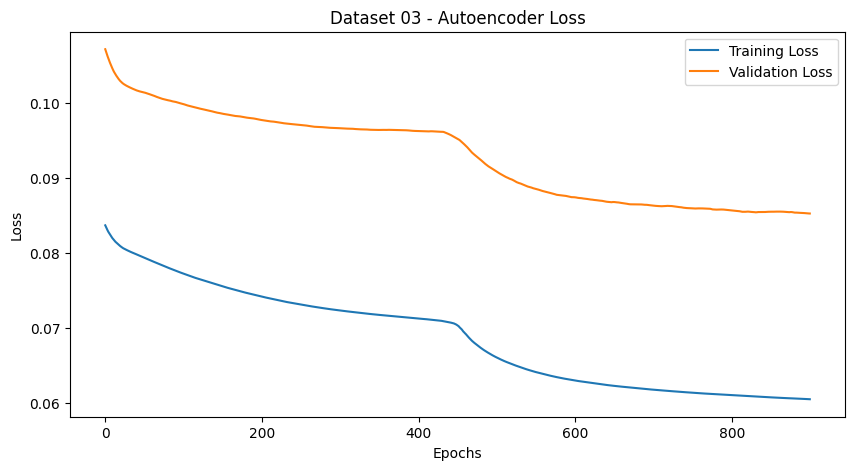

In [60]:
def plot_loss(history, title, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()

plot_loss(history_03, 'Dataset 03 - Autoencoder Loss', 'dataset03_loss.png')